# DAVID visualization

## Index
A. Dot-plot
- Visualize one annotational chart
- Visualize two annotational charts

B. Bar-plot

### A. Dot-plot
- __Visualize one annotational chart__
- Visualize two annotational charts

### Step 1. Call, define the modules and functions.


In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


def preprocess_david(data):
    # GeneRatio = Count / List Total
    data.loc[:, 'GeneRatio'] = data.loc[:, 'Count'] / data.loc[:, 'List Total']

    # BgRatio = Pop Hits / Pop Total
    data.loc[:, 'BgRatio'] = data.loc[:, 'Pop Hits'] / data.loc[:, 'Pop Total']

    # log2 transformed fold enrichment
    data.loc[:, 'log2 Fold Enrichment'] = np.log2(data.loc[:, 'Fold Enrichment'])
    #data[:, 'log2 Fold Enrichment'] = np.log2(data[:, 'Fold Enrichment'])
    
    # Replace 0 to min value from that column
    pvals = ['PValue', 'Bonferroni', 'Benjamini']
    for pval in pvals:
        # Assuming your DataFrame is named 'df'
        filtered_df = data[data[pval] != 0]
        min_non_zero = filtered_df[pval].min()

        #min_non_zero = data[pval][data[pval] != 0].min
        data[pval] = data[pval].replace(0, min_non_zero)

    # Fisher E
    data['-log10(PValue)'] = np.log10(data['PValue'])
    data.loc[:, '-log10(PValue)'] *= -1
    return data


def pick_go_term(data, type="bp", x="fold_enrichment", p="pvalue", top=10):   
    # axis_Y (Annotation Term)
    global fig_title
    global axis_X
    global adj_p

    if type == "bp":
        data_tmp = data[data['Category'] == "GOTERM_BP_DIRECT"]
        fig_title = "GOBP"
    elif type == "cc":
        data_tmp = data[data['Category'] == "GOTERM_CC_DIRECT"]
        fig_title = "GOCC"
    elif type == "mf":
        data_tmp = data[data['Category'] == "GOTERM_MF_DIRECT"]
        fig_title = "GOMF"
    elif type == "kegg":
        data_tmp = data[data['Category'] == "KEGG_PATHWAY"]
        fig_title = "KEGG"
    else:
        raise ValueError

    # axis_X ()
    if x == "fold_enrichment":
        axis_X = "log2 Fold Enrichment"
    elif x == "gene_ratio":
        axis_X = "GeneRatio"
    elif x == "fisherp":
        axis_X = "-log10(PValue)"
    else:
        raise ValueError

    # p
    if p == "pvalue":
        adj_p = "PValue"
        thres = 0.05
    elif p == "fdr":
        adj_p = p.upper()
        thres = 0.01
    else:
        raise ValueError
    
    # Picking
    data_p = data_tmp[data_tmp[adj_p] <= thres]
    data_sort = data_p.sort_values(by=axis_X, ascending=False)
    data = data_sort[:top]
    return data


def plot(data):
    # GeneOntology Dot Plot Generator
    font = {'family':'Arial',
            'weight':'normal',
            'size':6}
    font_ticks = {'family':'Arial',
                'weight':'normal',
                'size':6}
    spectrum_colors = sns.color_palette("coolwarm_r", as_cmap=True)


    fig = plt.figure(figsize=(1, 2), dpi=150, facecolor="white")
    scatterplot = sns.scatterplot(data, x=axis_X, y="Term", size="Count", hue=adj_p, palette='coolwarm_r', legend="brief")

    # Custom legends
    h, l = scatterplot.get_legend_handles_labels()
    #plt.legend(h[6:], l[6:], bbox_to_anchor=(1.0, 0.5), loc="upper left", title="Counts", frameon=False, borderaxespad=0., fontsize=6, title_fontsize=6)
    plt.legend(h[6:], l[6:], bbox_to_anchor=(1.0, 0.5), loc="upper left", frameon=False, borderaxespad=0., fontsize=6, title_fontsize=6)


    # ColorBar
    cmap = cm.bwr
    vmin = data['PValue'].min()
    vmax = data['PValue'].max()
    vmm = vmin + vmax
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=plt.gca(), fraction=0.04, pad=0.1, anchor=(1.0, 0.9), format='%.0e')
    cbar.ax.spines['outline'].set_visible(False) # outline remove
    cbar.ax.tick_params(size=0, labelsize=6) # remove ticks
    #cbar.set_label('Adj.P', rotation=270, size=6)


    # Details
    plt.title(str(fig_title), font='Arial', size=8)
    plt.xlabel(str(axis_X), fontdict=font)
    plt.ylabel(None)
    plt.xticks(fontproperties=font_ticks)
    plt.yticks(fontproperties=font_ticks)

    # Add grid lines to both x and y axes with gray color and a lower z-order
    plt.grid(True, color='gray', linewidth=0.2, zorder=0)

    plt.show()

### Step 2. Import data and plot

#### Example.
X: Gene Ratio, Y: Annotation:GOCC, Hue: Adjusted p-value, Dot size: Counts

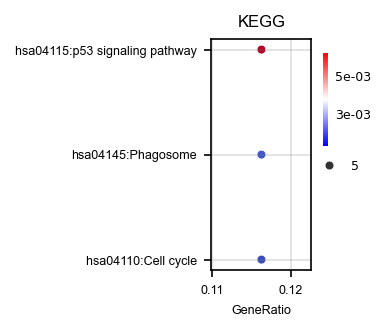

In [27]:
import os
import pandas as pd

# Import the DAVID annoational table.txt
USER = os.getcwd()
DPATH = 'C:/Users/simhc/Downloads/netosis-david.txt'
DPATH1 = "C:/Users/simhc/OneDrive/Documents/_ProteomicsLAB/_proj/PCa_HMGN1/_proteogenomic/david-kd-up-only.txt"
df = pd.read_csv(filepath_or_buffer=DPATH1, sep='\t', encoding='utf-8')

# Preprocessing, picking up what you want to visualize then plot them.
df_ready = preprocess_david(df)
df_plot = pick_go_term(df_ready, type="kegg", x="gene_ratio", p="pvalue", top=10)
plot(df_plot)

#### Bug report
Noted two replicated "Count" legend title.